# Extracting Layers from ARIA standard GUNW products

**Author**: Brett A. Buzzanga, David Bekaert - Jet Propulsion Laboratory

This notebook is intended to demonstrate interferogram manipulation capabilties of the ARIA-tools.
Specifically, we will show how to use extractProduct.py to:
- merge together interferograms along a common track
- crop using a refernce bounding box or shapefile
- apply a water mask?
- extract data layers:
    - unwrappedPhase, coherence, amplitude, 
- and metadata layers:
    - product bounding box, bPerpendicular, bParallel, incidenceAngle, lookAngle, azimuthAngle

To illustrate the usage of extractProduct.py we will use two acquisitions processed by the ARIA system covering Hawai'i.

## 0. Initial setup of the notebook

The cell below performs initial setup of the notebook and must be run every time the notebook is used. It loads the required modules into our python environment and using ***import*** command. You must add the path to the ARIA-tools to your path, if they are not already there. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run before restarting.

In [100]:
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

## set the paths to where you will keep your data and results
data_dir = os.path.join(os.getcwd(), 'data', 'track_124')
res_dir  = os.path.join(os.getcwd(), 'res')

## add the aria tools to your path
path_tools = os.path.join(os.path.expanduser('~'), 'Software_InSAR', 'ARIA-tools_git', 'tools', 'python')
os.sys.path.append(path_tools)
os.environ["PATH"] += os.pathsep + path_tools

### 1.0. Download the data
Here we show how to use the standard wget tool to download two scenes over Hawi'i, track 124. The Big Island is split in the along-track direction between the two scenes.
Note that you will need to run this cell **everytime** you run the notebook so the variables to the interferograms are set (the data won't be downloaded again).

In [101]:
ifg1 = 'S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc'
ifg2 = 'S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc'
path_ifg1 = os.path.join(data_dir, ifg1.split('/')[1])
path_ifg2 = os.path.join(data_dir, ifg2.split('/')[1])

url_base = 'https://aria-products.jpl.nasa.gov/search/dataset/grq_v2.0.1_s1-gunw-released/'
args = '--no-clobber --load-cookies /tmp/cookies.txt --save-cookies /tmp/cookies.txt --keep-session-cookies -P {}'.format(data_dir)
for ifg in [ifg1, ifg2]:
    cmd = '{} {}{}'.format(args, url_base, ifg)
    !wget {cmd}


--2019-05-01 18:43:59--  https://aria-products.jpl.nasa.gov/search/dataset/grq_v2.0.1_s1-gunw-released/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc
Resolving aria-products.jpl.nasa.gov (aria-products.jpl.nasa.gov)... 128.149.112.114
Connecting to aria-products.jpl.nasa.gov (aria-products.jpl.nasa.gov)|128.149.112.114|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: http://hysds-aria.s3-website-us-west-2.amazonaws.com/datasets/interferogram/v2.0.1/2019/03/04/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc [following]
--2019-05-01 18:44:00--  http://hysds-aria.s3-website-us-west-2.amazonaws.com/datasets/interferogram/v2.0.1/2019/03/04/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1/S1-GUNW-A-R-124-tops-20190304_20190226-04

### 1.1 Merging of the two scenes
Here we demonstrate how to extract the **amplitude** data of the scenes.
Inputting both scenes to extracProduct.py program will automatically merge them.
We also show how to automatically download the required digital elevation model (DEM).
The data will be saved the **res_dir** we set above.

In [102]:
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
# ifgs   = '{}'.format(path_ifg1)
# cmd    = "--file '{}' --layers '{}' --workdir {} --demfile=Download".format(ifgs, ','.join(layers), res_dir)
cmd    = "--file '{}' --layers '{}' --workdir {}".format(ifgs, ','.join(layers), res_dir)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
print ('Finished extracting {}'.format(layers))

Running extractProduct.py --file '/Users/bb/Software_InSAR/ARIA-tools_git/tools/python/data/track_124/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/data/track_124/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' --layers 'amplitude' --workdir /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/res
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

All 2 input files successfully passed!
Group spatiotemporally continuous IFGs.

All 1 input files successfully passed!


##################################

### 1.1. View Extracted Amplitude
The extraction tool creates a raster with basename of the interferogram dates and no extension in res_dir/amplitude.
It also creates a .vrt file (for use with GDAL, see the GDAL Notebook[LINK]), and an .xml file that is neede for ISCE[LINK] tools such as mdx.py.


Here we demonstrate a quick look at the resulting amplitude data using GDAL and matplotlib.

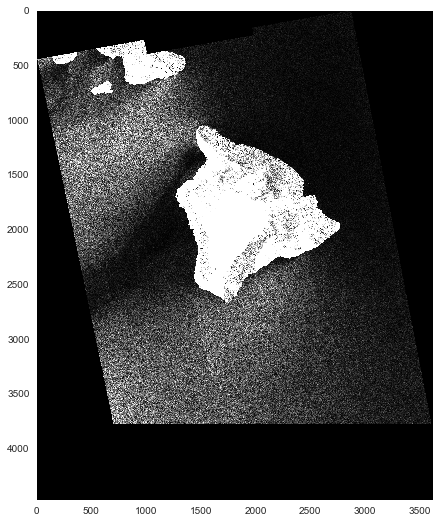

In [103]:
path_ifg = os.path.join(res_dir, 'amplitude', '20190304_20190226')
ds  = gdal.Open(path_ifg, gdal.GA_ReadOnly)
arr = ds.ReadAsArray()

fig, axes = plt.subplots(figsize=(16,9))
cmap = plt.cm.Greys_r
cmap.set_under('black')
# note that you may have to adjust vmax for different scens
axes.imshow(arr, cmap=cmap, vmax=2000)
axes.grid(False)


### 1.2. View Product Bounding Bax
Additionally, 2 geojson files (.shp) are created in res_dir/productBoundingBox.
The one with basename of the interferogram dates is bounding box of each scene? and the productBoundingBox_total.shp is total product? (will check later)

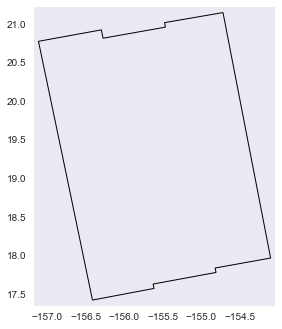

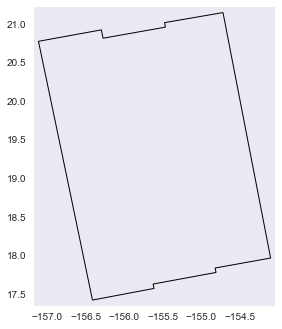

In [104]:
# need to fix import 
os.chdir(path_tools)
from shapefile_util import plot_shapefile
product_bbox  = os.path.join(res_dir, 'productBoundingBox', '20190304_20190226.shp')
product_total = os.path.join(res_dir, 'productBoundingBox', 'productBoundingBox_total.shp')

plot_shapefile(product_bbox)
plot_shapefile(product_total)



## 2. Crop the merged dataset

### 2.1 We'll now crop out most of the water around the Big Island using a lat/lon bounding box

In [119]:
SNWE = '18.8 20.3 -156.1 -154.5'
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
cmd    = "-f '{}' -l '{}' -w {} --bbox '{}' ".format(ifgs, ','.join(layers), res_dir, SNWE)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
print ('Finished cropping {}'.format(layers))

Running extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools_git/tools/python/data/track_124/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/data/track_124/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'amplitude' -w /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/res --bbox '18.8 20.3 -156.1 -154.5' 
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

Shapefile /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/res/user_bbox.shp created for input user bounds.
All 2 input files successf

### 2.2 View cropped Amplitude
The cropping routine will have produced a shapefile with our bounding box (user_bbox.shp) in res_dir, and overwritten the files in the res_dir/amplitude.

Let's take a quick look at the cropped data.

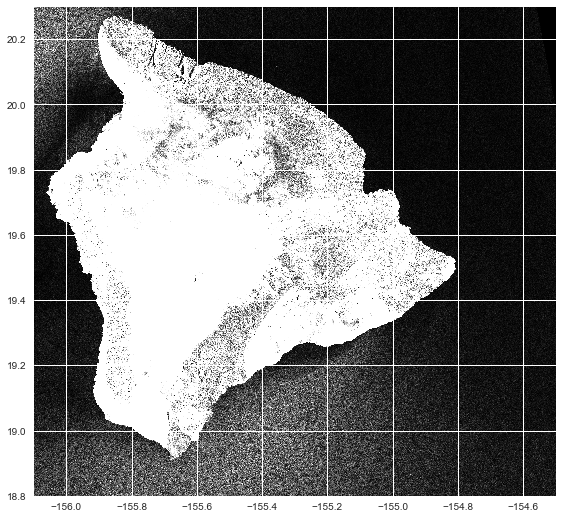

In [106]:
path_ifg = os.path.join(res_dir, 'amplitude', '20190304_20190226')
ds  = gdal.Open(path_ifg, gdal.GA_ReadOnly)
trans = ds.GetGeoTransform(); xsize = ds.RasterXSize; ysize = ds.RasterYSize
extent = [trans[0], trans[0] + xsize * trans[1], trans[3] + ysize*trans[5], trans[3]]
arr = ds.ReadAsArray()

fig, axes = plt.subplots(figsize=(16,9))
cmap = plt.cm.Greys_r
cmap.set_under('black')
# note that you may have to adjust vmax for different scenes
axes.imshow(arr, cmap=cmap, vmax=2000, extent=extent)

### 2.3 User Defined Shapefile
Instead of using a bbox of coordinates, the user can specify a pre-existing shapefile to crop to.
Here we demonstrate how the input to extractProducy.py should look using the shapefile that was created from the bounding box given in step 2.1. This will again overwrite the raster and associated metadata in the res_dir/amplitude folder. You can check the output with the above plotting call; it should be identical.

**Note** be sure to run cell 2.1 before running the following cell.

In [107]:
shp    = os.path.join(res_dir, 'user_bbox.shp')
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
cmd    = "-f '{}' -l '{}' -w {} --bbox '{}'".format(ifgs, ','.join(layers), res_dir, shp)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
print ('Finished cropping with shapefile {}'.format(layers))

Running extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools_git/tools/python/data/track_124/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/data/track_124/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'amplitude' -w /Users/bb/Software_InSAR/ARIA-tools_git/tools/python/res --bbox '/Users/bb/Software_InSAR/ARIA-tools_git/tools/python/res/user_bbox.shp'
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

EPSG
EPSG
All 2 input files successfully passed!
Group spatiotemporally continuous IFGs.

Al

### 1.2.  Extract and save the orbital information to disk.
We now provide the downloaded DEM in input variable **dem**.
We provide the layer names as **layers**.
For details on orbital charateristics, see https://earth.esa.int/handbooks/asar/CNTR5-5.html

In [108]:
dem      = './res/SRTM_3arcsec'
layers   = ['bParallel', 'incidenceAngle', 'lookAngle', 'azimuthAngle']
cmd      = "-f {} --layers '{}' -w {} --demfile=Download".format(fileName, ','.join(layers), dest)

!extractProduct.py {cmd}
print ('Finished Processing {}'.format(layers))

NameError: name 'fileName' is not defined

## END EXTRACT PRODUCT ------------------------------------------------------------------------
Below here is template for further development

### 1.2 Reading the metadata

Now we can access to the metadata of the file and see how it is structured. The cell below shows how to read the metadata into a variable and then print it.

In [ ]:
##Retrieve an overview of the file content##
dataInfo = gdal.Info(ds)
print(dataInfo)

**This output can be generated by using the command below in your terminal under the JupyterDocs folder**

gdalinfo ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc

## 2. Accessing to subdatasets

We can access to subdatasets, such as unwrapped phase, and their metadata the same way we accessed the products. We need to open the specific subdataset, which we can obtaing their location in the file using the information we printed above, and again read its metadata.

In [ ]:
##Open and retrieve information of the unwrapped phase##

unwPhase = gdal.Open("NETCDF:"+fileName+":/science/grids/data/unwrappedPhase")
unwPhaseInfo = gdal.Info(unwPhase)
print(unwPhaseInfo)

**This output can be generated by using the command below in your terminal under the JupyterDocs folder**

gdalinfo gdalinfo NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/grids/data/unwrappedPhase

## 3. Reading the subdataset into an array and plotting

### 3.1 Reading the subdataset into an array

Reading data sets into python arrays enables us to take advantage of the whole flexibility and operational capabilities of python. Here were are going to read our unwrapped phase into an array which is technically a 2D matrix in this case. Python arrays are not necessarily always matrices and have the capabililty to expand into n-dimensions. The cell below shows how to read unwrapped phase into a variable. We are using variable, unwPhase, which is the instance we opened the unwrapped phase subdataset in the previous cell and calling GetRasterBand(1). We are calling raster band 1 because our subdataset has only 1 band as we see in the output of the previous cell.

In [ ]:
unwData = unwPhase.GetRasterBand(1).ReadAsArray()

### 3.2 Retrieving the information required for plotting

When we want to plot the data using python we need to extract some more information from the subdataset. We are going to need "No Data Value", "Projection" and "Corner Coordinates". The cell below shows how to extract this information from unwrapped phase subdataset.

In [ ]:
##Get No Data Value##
NDV = unwPhase.GetRasterBand(1).GetNoDataValue()

##Get Projection##
projection = osr.SpatialReference()
projection.ImportFromWkt(unwPhase.GetProjectionRef())

##Get corner coordinates##
ulLon, Lonres, Lonskew, ulLat, Latskew, Latres  = unwPhase.GetGeoTransform()
lrLon = ulLon + (unwPhase.RasterXSize * Lonres)
lrLat = ulLat + (unwPhase.RasterYSize * Latres)

###Let's round corner coordinates to the same number of digits as given in previous cell###
ulLon = np.round(ulLon,7)
ulLat = np.round(ulLat,7)
lrLon = np.round(lrLon,7)
lrLat = np.round(lrLat,7)

###Corner coordinates taken from previous cell###
print('''
Corner Coordinates from previous cell:
Upper Left  ( -81.8662500,  42.6670833)
Lower Left  ( -81.8662500,  40.7954167)
Upper Right ( -78.3395833,  42.6670833)
Lower Right ( -78.3395833,  40.7954167)
''')

###Corner coordinates calculated in this cell###
print('''
Corner Coordinates calculated in this cell: ''',
'''Upper Left: ''', (ulLon,  ulLat),
'''Lower Left: ''', (ulLon,  lrLat),
'''Upper Right: ''', (lrLon,  ulLat),
'''Lower Right: ''', (lrLon,  lrLat), sep='\n')


### 3.3 Masking the array 
After getting the required information for a plot let's do a final operation in the dataset and mask the no-data areas using the No Data Value (NDV) we got in the previous cell. We can carry out this operation using numpy module of python as below.

In [ ]:
unwDataMasked = np.ma.masked_array(unwData, mask=unwData==NDV, fill_value=999999)

### 3.4 Plotting the data

We can use various methods to plot our dataset. The cell below is showing how to plot using Basemap module.

Before starting to use Basemap module, we need to make sure that our **PROJ_LIB** directory has the epsg. Unfortunately this file is not automatically installed with PROJ4 version 6 but it comes with the previous versions. Since we only installed previous versions to use with Basemap, we can copy the epsg file from that directory (in case of conda installation of Basemap, /python/install/dir/share/proj/epsg) to our **PROJ_LIB** directory (/my/proj/install/dir/share/proj)

Make sure that you have basemap-data-hires package installed for a high resolution plot. The command below can be used for Anaconda python installations.

conda install -c conda-forge basemap-data-hires


**NOTE TO SELF:
TODO list to improve the cell below**
- automatic projection extraction
- plotted data is flipped (related to projection?)

In [ ]:
from mpl_toolkits.basemap import Basemap

plt.rcParams['figure.figsize'] = [20, 8]

m = Basemap(projection='cyl',
            llcrnrlat = lrLat,
            llcrnrlon = ulLon,
            urcrnrlat = ulLat,
            urcrnrlon = lrLon,
            resolution='h')

lats = np.linspace(lrLat,ulLat,unwDataMasked.shape[0])
lons = np.linspace(ulLon,lrLon,unwDataMasked.shape[1])
x, y = m(*np.meshgrid(lons,lats))

m.contourf(x,y,np.flipud(unwDataMasked),cmap='viridis')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')

m.drawparallels(np.arange(m.latmin,m.latmax,1),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax,1),labels=[0,0,0,1])
# m.colorbar()
m.fillcontinents(color='0.8', lake_color='#73C2FB',alpha=0.5,zorder=0)




## 4. Cropping the data at given boundaries and creating KMZ files

### 4.1 Exporting the data as KMZ
In this section we are going to use gdal capability to export the data into a KMZ file which can be viewed in Google Earth. We can do this operation using the simple gdal.Translate function. We only need to define output name, input data (unwPhase) and the options. We define the options using gdal.ParseCommandLine() function which allows us to pass gdal_translate options in notebook environment.

**Note:** Be aware that input data here is not our python array but the unwPhase which we opened using gdal.Open in previous section.

In [ ]:
translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png'))
kmzFile = gdal.Translate("unwrappedPhase.kmz", unwPhase, options=translateOptions)

### 4.2 Cropping the data and exporting as KMZ

By only adding the **projwin** option into gdal.TranslateOptions we can crop the data and export the cropped plot into a KMZ file

In [ ]:
translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png -projwin -81.00 42.30 -80.00 41.50'))
kmzFileCrop = gdal.Translate("unwrappedPhaseCrop.kmz", unwPhase, options=translateOptions)